<a href="https://colab.research.google.com/github/eoinleen/AKTA-Prime_final/blob/main/Final_SEC_AKTA_prime_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SEC Data Analyzer - Starting Analysis...

SEC DATA ANALYZER - FILE UPLOAD
Please upload your AKTA SEC data file (.xls or .xlsx)
Google Colab detected - using Colab file upload...


Saving 20250326-human_mysm1.xlsx to 20250326-human_mysm1 (5).xlsx
File uploaded successfully: 20250326-human_mysm1 (5).xlsx

Loading data from 20250326-human_mysm1 (5).xlsx...
Found 18 columns in the data file
File contains 960 rows of data

Data Summary:
Absorbance (mAu) range: -0.029 to 269.365
Volume (ml1) range: 0.00 to 103.91
Loaded 960 valid data points successfully

Main peak detected: 269.37 mAU at 65.77 ml

Saving plot as: sec_analysis_plot.png
Plot saved successfully: sec_analysis_plot.png
File saved to your current directory with transparent background.

Analysis completed successfully!
Displaying plot...


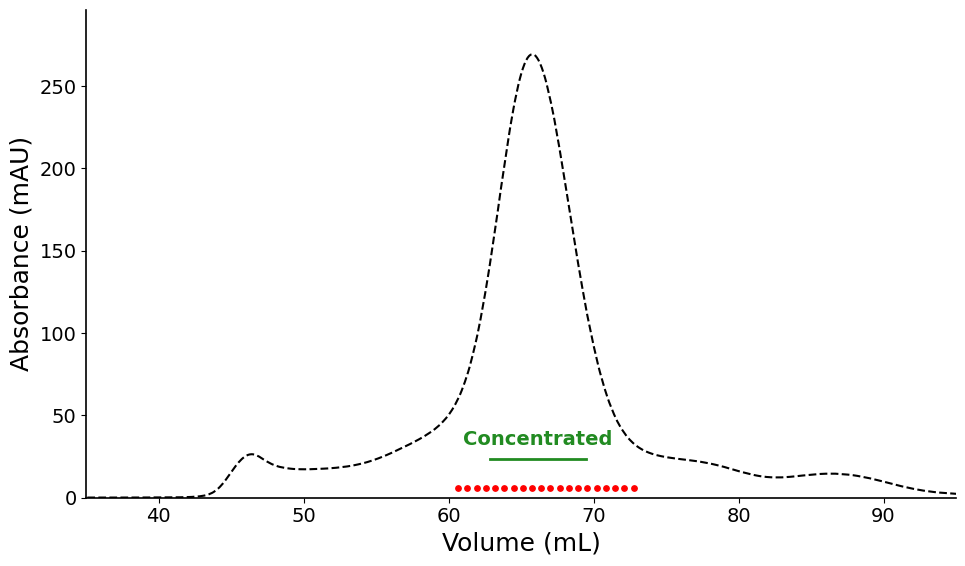

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import os
import warnings
from pathlib import Path

# ==============================================================================
# CONFIGURATION SECTION - MODIFY THESE VALUES AS NEEDED
# ==============================================================================
# File path options:
FILE_PATH = None  # Set to None to trigger file upload prompt

# Fraction collection range (in mL) - adjust for your bottom graph
FRACTION_START = 60.65
FRACTION_END = 72.75

# Concentrated fractions range (subset of fractions to be concentrated)
CONCENTRATE_START = 62.85  # Starting point for concentration
CONCENTRATE_END = 69.45    # Ending point for concentration

# Display range on the x-axis (in mL)
X_AXIS_MIN = 35
X_AXIS_MAX = 95

# Column indices for your specific AKTA file format (0-based indices)
VOLUME_COLUMN = 0        # ml (volume) column
ABSORBANCE_COLUMN = 1    # mAu (absorbance) column
CONDUCTIVITY_COLUMN = 3  # mS/cm (conductivity) column
FRACTION_VOL_COLUMN = 12  # ml for fractions
FRACTION_NUM_COLUMN = 13  # Fraction numbers

# Styling settings to match top graph
SHOW_CONDUCTIVITY = False     # Hide conductivity for cleaner look
SAVE_OUTPUT = True
AUTO_DOWNLOAD = True
OUTPUT_PATH = './sec_plot.png'
DOWNLOAD_FILENAME = 'sec_analysis_plot.png'
SHOW_LEGEND = False           # Clean look without legend
SHOW_FRACTION_LABEL = False   # Clean look
SHOW_CONCENTRATION = True     # Show concentrated fractions
USE_TOP_GRAPH_STYLE = True    # New flag for consistent styling

# Font sizes for publication-quality figures
FONT_SIZES = {
    'general': 18,      # Overall font size
    'title': 20,        # Title font size
    'labels': 18,       # Axis label font size
    'ticks': 14,        # Tick label font size
    'annotations': 14   # Annotation font size
}

# ==============================================================================

def get_file_path():
    """Get file path either from configuration or by prompting user for upload."""
    global FILE_PATH

    if FILE_PATH is not None:
        if os.path.exists(FILE_PATH):
            print(f"Using specified file: {FILE_PATH}")
            return FILE_PATH
        else:
            print(f"Warning: Specified file path does not exist: {FILE_PATH}")
            print("Falling back to file upload prompt...")

    print("\n" + "="*60)
    print("SEC DATA ANALYZER - FILE UPLOAD")
    print("="*60)
    print("Please upload your AKTA SEC data file (.xls or .xlsx)")
    print("="*60)

    try:
        from google.colab import files
        print("Google Colab detected - using Colab file upload...")
        uploaded = files.upload()
        if not uploaded:
            raise ValueError("No file was uploaded")
        filename = list(uploaded.keys())[0]
        print(f"File uploaded successfully: {filename}")
        return filename

    except ImportError:
        try:
            from ipywidgets import FileUpload
            from IPython.display import display
            print("Jupyter environment detected - using widget upload...")
            uploader = FileUpload(accept='.xls,.xlsx', multiple=False, description='Upload SEC Data')
            display(uploader)
            print("Please use the upload widget above to select your file.")
            return None
        except ImportError:
            print("Manual file path input mode...")
            while True:
                file_path = input("Enter file path: ").strip()
                if not file_path:
                    print("No path entered. Please try again.")
                    continue
                if os.path.exists(file_path):
                    print(f"File found: {file_path}")
                    return file_path
                else:
                    print(f"File not found: {file_path}")
                    retry = input("Try again? (y/n): ").strip().lower()
                    if retry != 'y':
                        raise FileNotFoundError("No valid file path provided")

def analyze_sec_data(file_path=None, config=None):
    """
    Analyze Size Exclusion Chromatography data from AKTA and create visualization
    with consistent styling to match the top graph.
    """
    if file_path is None:
        file_path = get_file_path()
        if file_path is None:
            print("No file provided. Please upload a file and try again.")
            return None, None, None

    # Default configuration
    default_config = {
        'header_row': 2,
        'fraction_range': (FRACTION_START, FRACTION_END),
        'concentrate_range': (CONCENTRATE_START, CONCENTRATE_END),
        'x_axis_limits': (X_AXIS_MIN, X_AXIS_MAX),
        'show_conductivity': SHOW_CONDUCTIVITY,
        'save_output': SAVE_OUTPUT,
        'auto_download': AUTO_DOWNLOAD,
        'output_path': OUTPUT_PATH,
        'download_filename': DOWNLOAD_FILENAME,
        'volume_column': VOLUME_COLUMN,
        'absorbance_column': ABSORBANCE_COLUMN,
        'conductivity_column': CONDUCTIVITY_COLUMN,
        'fraction_vol_column': FRACTION_VOL_COLUMN,
        'fraction_num_column': FRACTION_NUM_COLUMN,
        'show_legend': SHOW_LEGEND,
        'show_fraction_label': SHOW_FRACTION_LABEL,
        'show_concentration': SHOW_CONCENTRATION,
        'use_top_graph_style': USE_TOP_GRAPH_STYLE
    }

    if config is None:
        config = {}
    conf = {**default_config, **config}

    # Verify input file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file not found: {file_path}")

    # Load data from file
    print(f"\nLoading data from {file_path}...")
    try:
        warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

        file_extension = Path(file_path).suffix.lower()
        if file_extension in ['.xls', '.xlsx']:
            df_raw = pd.read_excel(file_path, header=conf['header_row'])
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")

        print(f"Found {len(df_raw.columns)} columns in the data file")
        print(f"File contains {len(df_raw)} rows of data")

        # Create DataFrame for analysis
        df = pd.DataFrame()

        # Extract data using specified column indices
        df['ml1'] = pd.to_numeric(df_raw.iloc[:, conf['volume_column']], errors='coerce')
        df['mAu'] = pd.to_numeric(df_raw.iloc[:, conf['absorbance_column']], errors='coerce')

        # Get conductivity data if requested
        if conf['show_conductivity']:
            cond_col = conf['conductivity_column']
            cond_vol_col = conf['volume_column'] + 2
            if cond_col < len(df_raw.columns):
                df['ml2'] = pd.to_numeric(df_raw.iloc[:, cond_vol_col], errors='coerce')
                df['mS/cm'] = pd.to_numeric(df_raw.iloc[:, cond_col], errors='coerce')
            else:
                df['ml2'] = df['ml1']
                df['mS/cm'] = 0
                conf['show_conductivity'] = False

        # Get fraction data
        frac_vol_col = conf['fraction_vol_column']
        frac_num_col = conf['fraction_num_column']

        if frac_vol_col < len(df_raw.columns):
            df['ml4'] = pd.to_numeric(df_raw.iloc[:, frac_vol_col], errors='coerce')
            if frac_num_col < len(df_raw.columns):
                df['Fractions'] = df_raw.iloc[:, frac_num_col].astype(str)
            else:
                df['Fractions'] = ""
        else:
            df['ml4'] = df['ml1']
            df['Fractions'] = ""

        # Clean the data
        df = df.dropna(subset=['ml1', 'mAu'])

        print(f"\nData Summary:")
        print(f"Absorbance (mAu) range: {df['mAu'].min():.3f} to {df['mAu'].max():.3f}")
        print(f"Volume (ml1) range: {df['ml1'].min():.2f} to {df['ml1'].max():.2f}")
        print(f"Loaded {len(df)} valid data points successfully")

    except Exception as e:
        raise RuntimeError(f"Error reading data file: {e}")

    # Analyze data
    results = {}

    if len(df) > 0:
        max_absorbance = df['mAu'].max()
        max_absorbance_idx = df['mAu'].idxmax()
        max_absorbance_vol = df.loc[max_absorbance_idx, 'ml1']
        results['max_absorbance'] = {
            'value': max_absorbance,
            'volume': max_absorbance_vol
        }
        print(f"\nMain peak detected: {max_absorbance:.2f} mAU at {max_absorbance_vol:.2f} ml")

    # Filter for fraction and concentration ranges
    fraction_start, fraction_end = conf['fraction_range']
    fractions_df = df[(df['ml1'] >= fraction_start) & (df['ml1'] <= fraction_end)]
    results['fractions'] = {'range': conf['fraction_range'], 'count': len(fractions_df)}

    concentrate_start, concentrate_end = conf['concentrate_range']
    concentrate_df = df[(df['ml1'] >= concentrate_start) & (df['ml1'] <= concentrate_end)]
    results['concentrate'] = {'range': conf['concentrate_range'], 'count': len(concentrate_df)}

    # Create visualization
    fig, ax1 = create_plot(df, fractions_df, concentrate_df, conf, results)

    # Handle output
    if conf['save_output']:
        if conf['auto_download']:
            download_plot(fig, conf['download_filename'])
        else:
            plt.savefig(conf['output_path'], dpi=300, bbox_inches='tight')
            print(f"\nPlot saved to {conf['output_path']}")

    return df, results, fig

def create_plot(df, fractions_df, concentrate_df, conf, results):
    """
    Create visualization with styling to match the top graph.
    """
    # Set font properties for publication quality
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': FONT_SIZES['general'],
        'axes.titlesize': FONT_SIZES['title'],
        'axes.labelsize': FONT_SIZES['labels'],
        'xtick.labelsize': FONT_SIZES['ticks'],
        'ytick.labelsize': FONT_SIZES['ticks']
    })

    # Create figure with appropriate size for publication
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot chromatogram with TOP GRAPH STYLING
    if conf.get('use_top_graph_style', True):
        # BLACK DASHED LINE to match top graph
        ax1.plot(df['ml1'], df['mAu'], linestyle='--', linewidth=1.5,
                 color='black', label='UV 280nm')
    else:
        # Original blue solid line
        ax1.plot(df['ml1'], df['mAu'], linestyle='-', linewidth=1.5,
                 color='blue', label='UV 280nm')

    # Calculate y-axis limits
    y_max = df['mAu'].max() * 1.1
    y_min = min(0, df['mAu'].min())
    ax1.set_ylim(y_min, y_max)

    # Add conductivity on secondary axis if enabled
    if conf['show_conductivity']:
        ax2 = ax1.twinx()
        ax2.plot(df['ml2'], df['mS/cm'], color='blue', alpha=0.6,
                 linestyle='-', linewidth=1, label='Conductivity')
        ax2.set_ylabel('Conductivity (mS/cm)', color='blue')
        ax2.tick_params(axis='y', colors='blue')

    # Plot fraction markers as RED DOTS to match top graph
    if len(fractions_df) > 0:
        # Create evenly spaced markers across the fraction range
        fraction_start, fraction_end = conf['fraction_range']
        marker_volumes = np.linspace(fraction_start, fraction_end,
                                   min(20, len(fractions_df)))  # Limit to ~20 markers
        marker_y_pos = y_min + (y_max - y_min) * 0.02

        ax1.scatter(marker_volumes, [marker_y_pos]*len(marker_volumes),
                    marker='o', color='red', s=15, label='Fractions', zorder=3)  # Smaller dots (s=15)

    # Add GREEN "Concentrated" line and text to match top graph
    if conf['show_concentration'] and len(concentrate_df) > 0:
        concentrate_start, concentrate_end = conf['concentrate_range']

        # Green color to match top graph
        green_color = '#228B22'  # Forest green

        # Position line just above the fraction markers
        line_y_pos = y_min + (y_max - y_min) * 0.08  # Just above fraction markers

        # Draw horizontal line only (no end brackets)
        ax1.plot([concentrate_start, concentrate_end], [line_y_pos, line_y_pos],
                 color=green_color, linewidth=2, zorder=4)

        # Add "Concentrated" text above the line
        text_x_pos = (concentrate_start + concentrate_end) / 2
        text_y_pos = line_y_pos + (y_max - y_min) * 0.02

        ax1.text(text_x_pos, text_y_pos, 'Concentrated',
                ha='center', va='bottom', color=green_color,
                fontsize=FONT_SIZES['annotations'], fontweight='bold')

    # Set x-axis limits
    ax1.set_xlim(conf['x_axis_limits'])

    # CLEAN STYLING to match top graph with transparent background
    ax1.set_facecolor('none')           # Transparent background
    fig.patch.set_facecolor('none')     # Transparent figure background
    fig.patch.set_alpha(0.0)            # Ensure transparency
    ax1.grid(False)                     # No grid for clean look

    # Remove top and right spines for cleaner look
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Make remaining spines thicker
    ax1.spines['left'].set_linewidth(1.2)
    ax1.spines['bottom'].set_linewidth(1.2)

    # Axis labels with proper font sizes
    ax1.set_xlabel('Volume (mL)', fontsize=FONT_SIZES['labels'])
    ax1.set_ylabel('Absorbance (mAU)', fontsize=FONT_SIZES['labels'])

    # Title (optional - remove if not needed for publication)
    # plt.title('Size Exclusion Chromatography', fontsize=FONT_SIZES['title'])

    # Legend only if requested
    if conf['show_legend']:
        if conf['show_conductivity']:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        else:
            ax1.legend(loc='upper right')

    plt.tight_layout()
    return fig, ax1

def download_plot(fig, filename):
    """Save plot locally with transparent background."""
    print(f"\nSaving plot as: {filename}")
    fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=True,
                facecolor='none', edgecolor='none')
    print(f"Plot saved successfully: {filename}")
    print("File saved to your current directory with transparent background.")

def run_analysis():
    """Convenience function to run the complete analysis workflow."""
    print("SEC Data Analyzer - Starting Analysis...")
    print("=" * 50)

    try:
        df, results, fig = analyze_sec_data()
        if fig is not None:
            print("\nAnalysis completed successfully!")
            print("Displaying plot...")
            plt.show()
            return df, results, fig
        else:
            print("Analysis failed - no data to display")
            return None, None, None
    except Exception as e:
        print(f"Error during analysis: {e}")
        return None, None, None

# Example usage
if __name__ == "__main__":
    # Run the analysis with consistent styling
    df, results, fig = run_analysis()